## What is Pythagorean expectation?

Pythagorean expectation is a formula that was originally derived by Bill James to be used in baseball. The objective of the formula was to estimate how many wins a team should have won based on the number of runs scored and runs allowed. You can read more about the theorem on [Wikipedia](https://en.wikipedia.org/wiki/Pythagorean_expectation) and [this article](https://towardsdatascience.com/pythagorean-expectation-in-sports-analytics-with-examples-from-different-sports-f5e599530a6c) that also presents few practical examples. Originally the form of the formula looks like this:
$$
W \approx \frac{(\text{runs scored}) ^ 2}{(\text{runs scored}) ^ 2 + (\text{runs allowed}) ^ 2} \text{,}
$$
where $W$ is the ratio of team's wins or **win percentage**.

However, we can generalize the above formula to other sports. If we use general notation, where $P_F$ denotes *points for* and $P_A$ denotes *points against*, then formula then converts to:

$$
W \approx \frac{{P_F} ^ x}{P_F ^ x + P_A ^ x} \text{.}
$$

Notice that in the second formula the exponents undefined. As seen in the first formula for baseball, Bill James used $x = 2$. Later there were some corrections for baseball to set $x = 1.83$. The value of $x$ depends on the nature of the sport, in football for example we see way lower number of points (goals) scored in comparison to basketball, so in order for the formula to be a good estimator of win percentage we need to set the $x$ value correctly.

## Example on Euroleague

In this article I will demonstrate how well does Pythagorean theorem apply to basketball, specifically to the strongest european competition of Turkish Airlines Euroleague.

In [1]:
# Load libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import fmin_l_bfgs_b
import os

In [2]:
# load and manipulate data
games = pd.read_csv(f"data/euroleague_games.csv")
games = games[["Season", "Part", "Round", "H_Team", "A_Team", "H_Score", "A_Score"]]
games = games.loc[games['Part'].isin(["REGULAR SEASON", "Regular"])]
games["Round"] = games.Round.str.extract('(\d+)')[0].astype(int)
games["H_Win"] = np.where(games["H_Score"] > games["A_Score"], 1, 0)
games["A_Win"] = np.where(games["H_Score"] < games["A_Score"], 1, 0)
games["count"] = 1

In [3]:
# function for calculating standings at the end of specific round
# function also calculates the pythagorean expectation with exponent 2
def output_table(input_games, season, round_=None):
    games_season = input_games[input_games["Season"] == season]
    max_round = round_
    if not max_round:
        max_round = max(games_season["Round"])
    games_season = games_season[games_season["Round"] <= max_round]

    table_home = games_season.groupby("H_Team").sum()[["H_Score", "A_Score", "H_Win", "count"]].reset_index()
    table_home = table_home.rename(columns={"H_Team": "Team", "H_Score": "Score", "A_Score": "Opponent_Score", "H_Win": "Win"})

    table_away = games_season.groupby("A_Team").sum()[["H_Score", "A_Score", "A_Win", "count"]].reset_index()
    table_away = table_away.rename(columns={"A_Team": "Team", "A_Score": "Score", "H_Score": "Opponent_Score", "A_Win": "Win"})

    table = pd.concat([table_home, table_away]).groupby(['Team']).sum().sort_values("Win", ascending=False).reset_index()

    table["Season"] = season
    table["W_ratio"] = table["Win"] / table["count"]
    table["pyth_classic"] = table["Score"] ** 2 / (table["Score"] ** 2 + table["Opponent_Score"] ** 2)
    return table

In [4]:
# Function to read image from disk (used for displaying logos on plots)
def get_image(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)


# Draws a nice plot of pyth. exp. vs. win ratio for each season.
# Also prints out correlation between pyth. exp. and win ratio.
def draw_plots(t, type_="pyth_classic", y_bounds=None):
    fig, ax = plt.subplots(int(len(seasons) / 2), 2, figsize=(18, 18), sharex="all", sharey="all")
    corr = {}
    m, b = [], []
    for i, season in enumerate(t.keys()):
        row, column = math.floor(i / 2), i % 2
        ax[row][column].scatter(t[season]["W_ratio"], t[season][type_], label=season)

        for idx, (w, pyth, team) in t[season][["W_ratio", type_, "Team"]].iterrows():
            team_name = team.replace(' ', '_')
            path_png = f"sports-logos/basketball/euroleague/img/{team_name}/{team_name}_small.png"
            path_jpg = f"sports-logos/basketball/euroleague/img/{team_name}/{team_name}_small.jpg"
            if os.path.exists(path_png):
                path = path_png
            else:
                path = path_jpg
            ab = AnnotationBbox(get_image(path, zoom=0.2), (w, pyth), frameon=False)
            ax[row][column].add_artist(ab)

        ax[row][column].set_title(season, fontdict={'fontsize': 18, 'color': 'white'})
        ax[row][column].grid("both")
        if y_bounds:
            ax[row][column].yaxis.set_ticks(np.arange(y_bounds[0], y_bounds[1], 0.1))
        ax[row][column].xaxis.set_ticks(np.arange(0, 1, 0.1))
        ax[row][column].yaxis.set_tick_params(labelbottom=True, colors="white")
        ax[row][column].xaxis.set_tick_params(labelbottom=True, colors="white")
        ax[row][column].tick_params(axis='both', which='major', labelsize=16)
        ax[row][column].set_facecolor("#f0f0f0")
        if type_ == "pyth_classic":
            m_i, b_i  = np.polyfit(t[season]["W_ratio"], t[season][type_], 1)
        else:
            m_i, b_i = 1, 0
        m.append(m_i)
        b.append(b_i)
        ax[row][column].plot(np.array([0.0, 0.9]), m_i * np.array([0.0, 0.9]) + b_i, color="green")
        corr[season] = np.round(t[season]["W_ratio"].corr(t[season][type_]), 3)
    fig.text(0.5, 0.08, 'W', ha='center', fontsize=22, color="white")
    fig.text(0.04, 0.45, "Pythagorean expectation", rotation="vertical", fontsize=22, color="white")
    plt.rcParams['figure.figsize'] = (10,10)
    plt.rcParams['savefig.dpi'] = 125
    plt.savefig(f"fig/{type_}.png", facecolor="#212121")
    corr_df = pd.DataFrame(data={"season": corr.keys(), "corr": corr.values()})
    return corr_df

For the analysis I used seasons of 2016/2017, 2017/2018, 2018/2019 and 2020/2021.

In [5]:
seasons = ["2016/17", "2017/18", "2018/19", "2020/21"]
tables = {season: output_table(games, season=season) for season in seasons}

Let's first draw a plot of Pythagorean expectation (Pyth. exp.) vs. winning ratio for each team in listed seasons. Here, I used $x = 2$ just to show that we can also draw conclusions with *original* exponent.

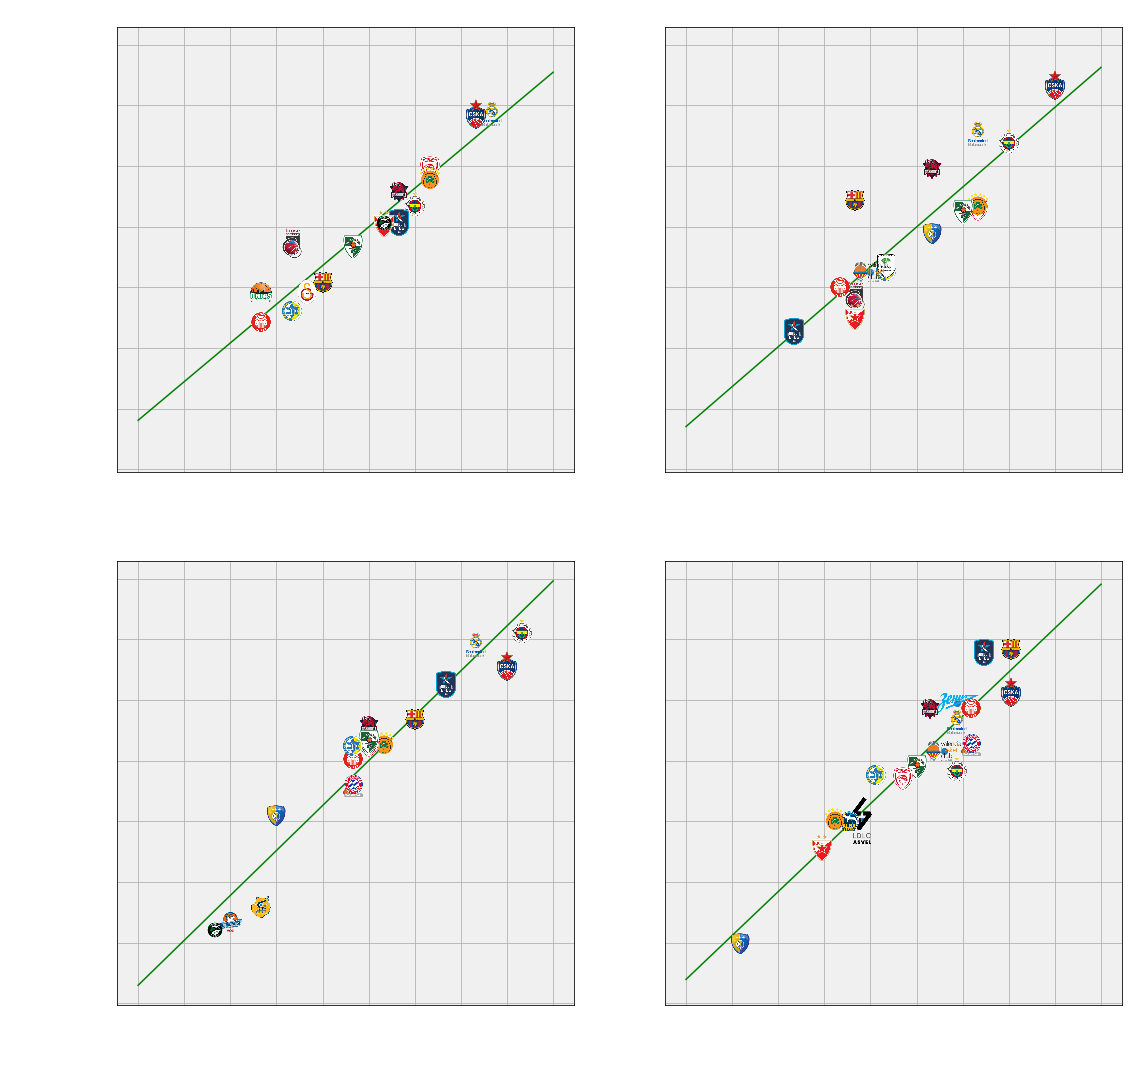

In [6]:
corr_classic = draw_plots(tables)

We observe that the values on vertical and horizontal axis are not in the same range, therefore we conclude that the $x = 2$ is not the best setting for this data. However, there definitely is a linear relationship between winning ratio and Pythagorean expectation. Green line in plots presents the line obtained by linear regression. Additionally, I also calculated Pearson correlation coefficients are also calculated to confirm the linear relationship:

In [7]:
corr_classic

,season,corr
0,2016/17,0.954
1,2017/18,0.887
2,2018/19,0.963
3,2020/21,0.945


### Finding the best exponent

We observe that there is obvious correlation between Pythagorean expectation and winning ratio, however $x = 2$ is not the choice to directly estimate winning ratio from points. To get the best fit for $x$ I constructed simple loss function:
$$
L(x) = \frac{\sum_{i=1}^n | W_i - \frac{{P_{F_i}} ^ x}{P_{F_i} ^ x + P_{A_i} ^ x}|}{n} \text{.}
$$
The loss function minimizes the average difference between winning ratio and Pythagorean expectation across all teams with respect to parameter $x$. For loss function minimization I used function `fmin_l_bfgs_b` from `scipy` library. The values were calculated for each season separately:



In [8]:
# function to minimize when calculating the exponent (we used the mean of abs(true win ratio - pyth expectation))
def loss(x, t):
    x = x[0]
    return np.mean(np.abs(t["W_ratio"] - t["Score"] ** x / (t["Score"] ** x + t["Opponent_Score"] ** x)))

In [9]:
fit_data = []
for season in seasons:
    x_, f_opt, d = fmin_l_bfgs_b(func=loss, args=(tables[season],), x0=np.array([2]), approx_grad=True)
    fit_data.append([season, np.round(x_[0], 2), np.round(f_opt, 3)])
    tab = tables[season]
    tab["pyth_fitted"] = tab["Score"] ** x_ / (tab["Score"] ** x_ + tab["Opponent_Score"] ** x_)
pd.DataFrame(data=fit_data, columns=["Season", "Best x", "error"])

,Season,Best x,error
0,2016/17,11.24,0.034
1,2017/18,10.95,0.056
2,2018/19,11.03,0.039
3,2020/21,11.10,0.041


The best fits for each of four seasons are pretty similar, $x \approx 11$. It could be that the $L(x)$ has multiple local minima and `fmin_l_bfgs_b` might not have returned the global minimum. We can verify that these $x$ values are indeed the best fit with respect to $L(x)$ using brute force by simply evaluating function from on range [0, 30] with step of 0.05.

In [10]:
def draw_errors(t):
    loss_data = []
    x_arrange =  np.arange(0, 30, 0.05)
    fig, ax = plt.subplots(int(len(seasons) / 2), 2, figsize=(18, 18), sharex="all", sharey="all")
    for i, season in enumerate(t.keys()):
        losses = []
        for x in x_arrange:
            losses.append(loss([x], tables[season]))
        best_x = np.round(x_arrange[np.argmin(losses)], 2)
        min_error = np.round(min(losses), 3)
        loss_data.append([season, best_x, min_error])
        row, column = math.floor(i / 2), i % 2
        ax[row][column].plot(x_arrange, losses)
        ax[row][column].set_title(season, fontdict={'fontsize': 18, 'color': 'white'})
        ax[row][column].grid("both")
        ax[row][column].yaxis.set_tick_params(labelbottom=True, colors="white")
        ax[row][column].xaxis.set_tick_params(labelbottom=True, colors="white")
        ax[row][column].tick_params(axis='both', which='major', labelsize=18)
        ax[row][column].set_facecolor("#f0f0f0")


    fig.text(0.5, 0.08, 'X', ha='center', fontsize=22, color="white")
    fig.text(0.04, 0.5, "Loss", rotation="vertical", fontsize=22, color="white")
    plt.rcParams['savefig.dpi'] = 125
    plt.savefig(f"fig/errors.png", facecolor="#212121")
    return pd.DataFrame(data=loss_data, columns=["Season", "Best x", "Error"])

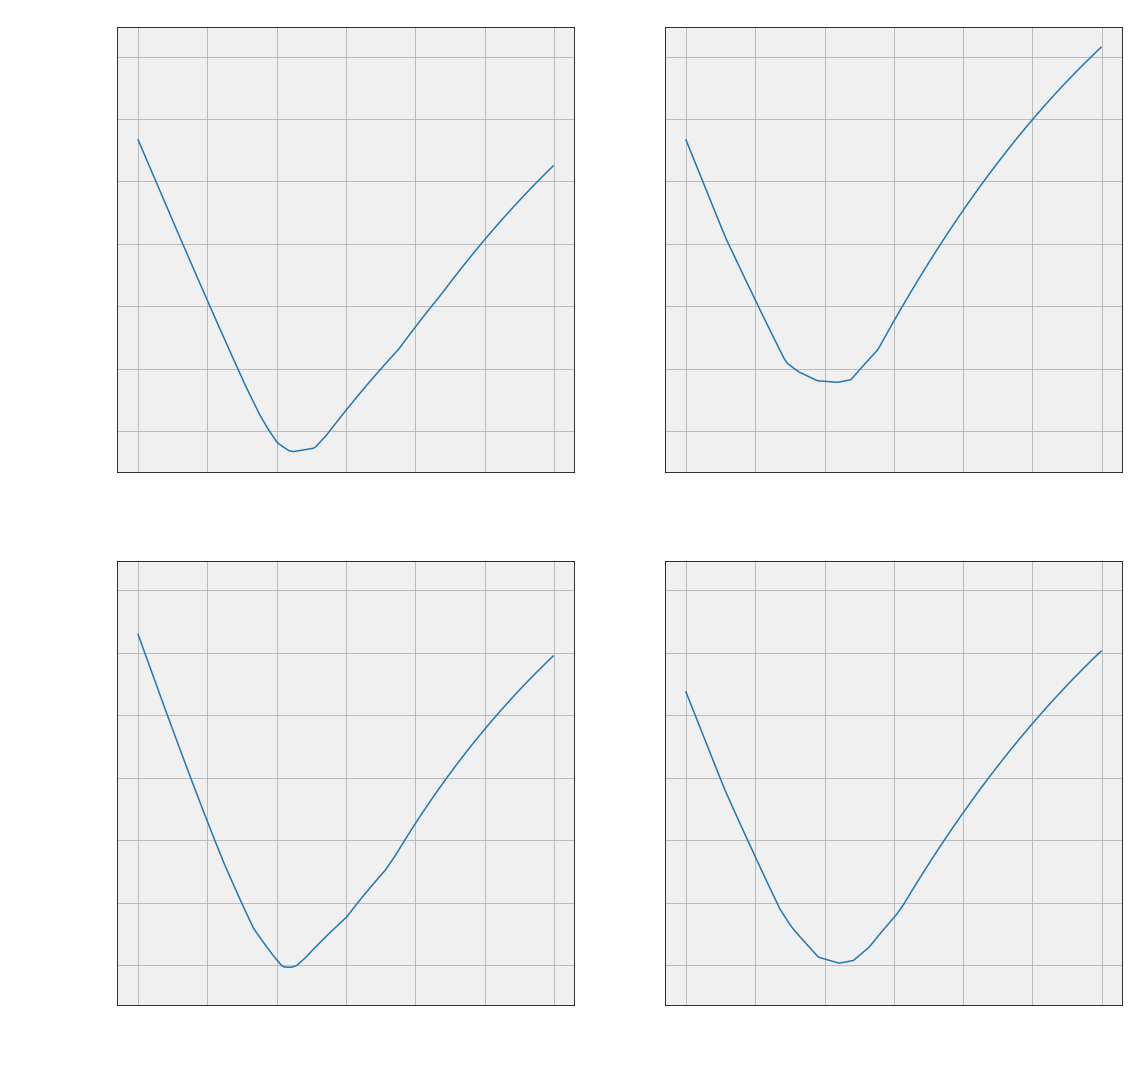

In [11]:
df_bf = draw_errors(tables)

These seem to be convex functions, so there should not be any problems getting the smallest error using any of two methods. Quick glance at Loss vs. x plots suffices to confirm that $x \approx 11$ seems to be a good fit for this data, however we also can also show values obtained using this method:

In [12]:
df_bf

,Season,Best x,Error
0,2016/17,11.25,0.034
1,2017/18,10.95,0.056
2,2018/19,11.00,0.039
3,2020/21,11.10,0.041


Comparing both tables, we conclude that the values are more or less identical.

### Pythagorean expectation using best exponent

Finally, we use the obtained values for $x$ to fix the Pythagorean expectation to get the best fit to given data. Note that green line in this case, does not represent the line obtained linear regression, it is simply just $y = x$ line.




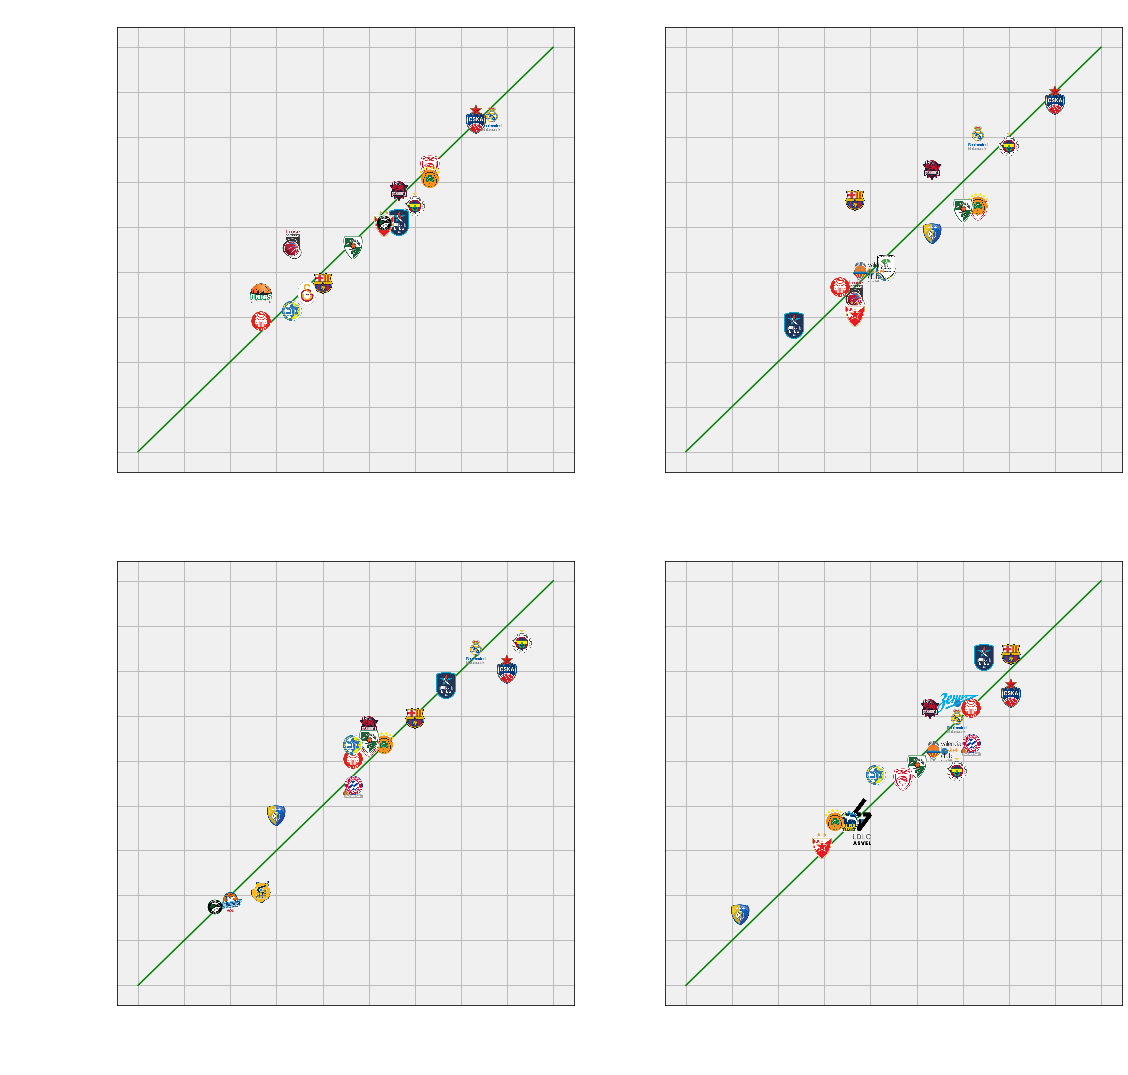

In [13]:
corr_fitted = draw_plots(tables, type_="pyth_fitted", y_bounds=(0, 1))

Again, we confirm strong linear correlation between Pythagorean expectation and winning ratio:

In [14]:
corr_fitted

,season,corr
0,2016/17,0.956
1,2017/18,0.884
2,2018/19,0.967
3,2020/21,0.944


Here, the interpretation of the plots should the following: the teams that are above the line managed to win fewer games than expected, considering the number of points scored and allowed. The teams that are below the line managed to win more games than expected.

Few examples:
<ul>
    <li>In 2017/2018 Barcelona finished 13th, however they definitely had potential to reach the Top 8</li>
    <li>In 2020/2021 Fenerbahce finished 7th with winning ratio close to 0.6, but it seems that they had some luck on their side, since their expected winning ratio is below 0.5, which would leave them without Top 8.</li>
</ul>